# Preface  

* 이 노트북의 자료는 [anarinsk/simsangjung](https://github.com/anarinsk/simsangjung)에서 찾으실 수 있습니다. 
* 어차피 심상정 의원이 블로그에 올리신 내용이므로 큰 문제는 없으리라고 봅니다. 

## Update history 

* (2018-09-04) 존경하는 최모 박사님께서 분위 개념을 알려주셔서 수정했습니다. 

# Preprocess Data 

* 이 섹션에서는 데이터 전처리를 다룬다. 별로 복잡한 코드는 없으므로 코드에 대한 설명을 생략하도록 하겠다.
* 마지막에 최종 결과를 DataFrame으로 남긴다.  
    * pivot style &rarr; `make_full_df(False)`
    * melt style &rarr; `make_full_df(True)`
    * 깃허브에 csv에 각각의 결과를 저장해 두었다. 
* 본 분석에서 데이터는 깃허브에서 바로 가져온다. 만일 클로닝해서 로컬 PC에서 실행하고 싶다면 아래 코드를 적절하게 바꾸면 된다.  

In [1]:
# Import packages 
import pandas as pd 
import numpy as np 
import os
from pathlib import Path 

In [2]:
# Set cwd in github 
this_cwd = Path('/home/anarinsk/github/simsangjung') 
this_github = 'http://raw.githubusercontent.com/anarinsk/simsangjung/master/raw_data/'
# 0: 이자, 1: 배당 
baedang_ija_2016 = this_github + 'BaeDangSoDeuk+IJaSoDeuk+CheonBunWi.xlsx'
# 0: 2015년, 1: 2014년, 2: 2013년 
geunro_2013_2015 = this_github + 'GeunRoSoDeukCheonBunWi.xlsx'
geunro_2016 = this_github + 'GeunRoSoDeukCheonBunWi2016Nyeon.xlsx'

# Load into padas DataFrame 

def load_xlsx(filename, sheet, col_names, skip=5):
    return pd.read_excel(filename, sheet_name=sheet, names=col_names, 
                  skiprows=skip, index_col=None, header=None)

#pd.read_excel(baedang_ija_2016, sheet_name=0, skiprows=0, index_col=None, header=None)
#pd.read_excel(geunro_2016, sheet_name=0, skiprows=0, index_col=None, header=None)

df1 = load_xlsx(baedang_ija_2016, 0, ['quintile', 'n', 'income', 'tax'])
df2 = load_xlsx(baedang_ija_2016, 1, ['quintile', 'n', 'income', 'tax'])
df3 = load_xlsx(geunro_2016, 0, ['quintile', 'n', 'total','income', 'dedection', 'standard', 'tax'])
df4 = load_xlsx(geunro_2013_2015, 0, ['quintile', 'n', 'total','income', 'dedection', 'standard', 'tax'])
df5 = load_xlsx(geunro_2013_2015, 1, ['quintile', 'n', 'total','income', 'dedection', 'standard', 'tax'])
df6 = load_xlsx(geunro_2013_2015, 2, ['quintile', 'n', 'total','income', 'dedection', 'standard', 'tax'])

In [3]:
# Define some functions 

def my_tidy(df, year, cat, do_melt=False): 
    df['year'] = year 
    df['cat'] = cat 
    df['quintile'] = range(1,1001, 1)   
    
    if do_melt == False:
        return df
    else: 
        return pd.melt(df, id_vars=['quintile', 'year', 'cat'])
    
def make_full_df(do_melt=False): 
    res = [my_tidy(d, y, c, do_melt) for d,y,c in 
               [[df1, 2016, "interest"], [df2, 2016, "dividends"], 
                [df3, 2016, "work"], [df4, 2015, "work"], [df5, 2014, "work"], [df6, 2013, "work"]]
        ]
    return pd.concat(res)

In [4]:
df_melt = make_full_df(True)
df_melt.reset_index(inplace=True) 

df_pivot = make_full_df(False)
df_pivot.reset_index(inplace=True) 

# save to csv 

df_melt.to_csv(this_cwd/'csv'/'melt.csv')
df_pivot.to_csv(this_cwd/'csv'/'pivot.csv')

# Our working df 
df = df_melt 

# Set default dir 
os.chdir(this_cwd)

/home/anarinsk/miniconda3/envs/withr/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Some Poor EDA(Explantory Data Analysis) 

* 그래프는 R의 ggplot2를 임포트해서 그렸다. 몇가지 코멘트는 아래 코드와 결과 사이에 남기도록 한다. 
* 조세자료지만, 일단 소득원(income 컬럼)에 관해서면 살펴보았다. 조세 자료에 관한 보다 세밀한 분석은 나중에 누군가가 더 잘 해주겠지. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
index       30000 non-null int64
quintile    30000 non-null int64
year        30000 non-null int64
cat         30000 non-null object
variable    30000 non-null object
value       30000 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1.4+ MB


In [6]:
### Start with kernel withr 
import warnings
warnings.filterwarnings('ignore')
import os
import rpy2.rinterface
os.environ.get("R_HOME")
#os.environ['R_HOME'] = '/usr/lib/R'
%reload_ext rpy2.ipython

In [7]:
%%R 
librarian::shelf(tidyverse, DescTools, ggsci, ggthemes, showtext)       

In [25]:
%%R -i df
readRDS('./rds/df.rds') %>% 
  select(-index) %>% 
  group_by(year, cat) %>% 
  mutate(
    q1000 = 1001 - as.integer(quintile), 
    q100 = 101 - (cut(quintile, breaks = 100) %>% as.integer()),
    q10 = 11 - (cut(quintile, breaks = 10) %>% as.integer())
    ) %>% 
  select(-quintile) -> tbl 

tbl %>% 
  filter(variable == 'income') %>% 
  group_by(year, cat) %>% 
  summarise(sum_yearcat = sum(value)) -> tbl2

tbl %>% 
  filter(variable == 'n') %>% 
  select(q1000, year, cat, value) %>% 
  rename(n = value) -> tbl3

tbl %>% 
  filter(variable == "income") %>% 
  left_join(tbl2, by = c("year", "cat")) %>% 
  left_join(tbl3, by = c('q1000', 'year', 'cat')) %>% 
  select(-variable) %>% 
  rename(income = value) -> income 

In [47]:
%%R
df_by_q <- function(var,is_work, df=income){
  
  if(is_work == T){
    df <- df %>% filter(cat == "work")
  } else {
    df <- df %>% filter(year == 2016)
  }
  var_enq = enquo(var)
  df %>% 
    group_by(year, cat, !!var_enq) %>% 
    summarise(
      value = sum(income), 
      share = value / first(sum_yearcat),  
      mean = value / sum(n)
    )
}
#
generate_2016_q <- function(var){
  
  var_enq <- enquo(var)
  str_extract_all(deparse(substitute(var)), "[0-9]") %>% 
    unlist() %>%  
    str_c(collapse="") -> title
    
  as.integer(title) -> n_q
  
      
  df_by_q(!!var_enq, F) %>% 
  filter(!!var_enq %in%  seq(n_q, n_q-9, -1)) %>% 
  ggplot() + 
  aes(x = factor(!!var_enq), y = share * 100) + 
  geom_col(width = 0.7) +
  scale_x_discrete(labels = c('10', '9', '8', '7', '6', '5', '4', '3', '2', '1')) +
  facet_grid(rows = vars(cat)) + 
  labs(
    title = str_glue("2016년 소득원천별 점유율 (상위 10개 분위, {title}분위 기준)"),  y = "비율 %", x = "순위") + 
  theme_bw()
}
#
generate_work_q <- function(var, q = seq_len(10)){
  var_enq <- enquo(var)
  str_extract_all(deparse(substitute(var)), "[0-9]") %>% 
    unlist() %>%  
    str_c(collapse="") -> title
  df_by_q(!!var_enq, T) %>% 
    filter(!!var_enq %in% q) %>% 
    ggplot() + 
    aes(x = year, y = share * 100, fill = factor(!!var_enq)) + 
    geom_col(width = 0.7) + 
    scale_x_discrete(limits=c(2013,2014,2015,2016)) + 
    theme_bw() + 
    scale_fill_simpsons(name = "분위") + 
    labs(
      title = str_glue("근로소득 {title}분위 분배율 변화 (2013--2016)"),
      x = "연도", 
      y = "누적 %"
    )
}

font_add_google("Gothic A1", "ga1")

# 분위별 분석 

* 심상정 의원의 자료로 살펴볼 수 있는 축은 두가지다. 
    * 하나는 배당소득, 이자소득, 근로소득을 비교하는 것이다. 이 자료는 2016년 자료만 제공되었다. 
    * 다른 하나는 2013년부터 2016년까지 4개 연도의 근로 소득을 비교하는 것이다. 

## 2016년 소득 종류별 비교 

* 일단 백분위를 십분위로 압축해서 종류별 소득의 규모를 살펴보자. 
* 아래 표에서 dividends는 배당소득, interest는 이자소득 그리고 work는 근로소득을 의미한다. 
* q1000은 천분위(원자료),  q100은 백분위 그리고 q10는 10분위로 자료를 재정리한 것이다. 
    * 작은 숫자일수록 많은 소득을 누리는 분위를 의미한다.  
* income은 각 종류별 소득의 분위합, n은 해당 구간의 샘플 수다. 
* n이 종류별로 각기 다르기 때문에 평균을 같이 살펴보았다. 예상대로 배당소득의 크기가 어마어마하고 이자소득의 크기 역시 상당하다. 
* 참고로 각 소득 종류별로 10분위 기준 상위 5개 구간의 소득 총액 및 1인당 평균을 살펴보면 아래의 표와 같다. 

In [37]:
%%R
income %>% 
  filter(year == 2016) %>% 
  group_by(cat, q10) %>%
  filter(q10 %in% c(10, 9, 8, 7, 6)) %>% 
  summarise(
    income2 = sum(income), 
    n2 = sum(n), 
    mean = (income2/n2) %>% sprintf("%#.2f", .)
  ) %>% 
  rename(
    income = income2, 
    n = n2
  ) %>% 
  arrange(cat, desc(q10)) %>% 
  knitr::kable()



|cat       | q10|      income|       n|mean     |
|:---------|---:|-----------:|-------:|:--------|
|dividends |  10| 13302677938|  891562|14920.64 |
|dividends |   9|   488018438|  891562|547.37   |
|dividends |   8|   173778883|  891562|194.92   |
|dividends |   7|    72608314|  891563|81.44    |
|dividends |   6|    30429304|  891562|34.13    |
|interest  |  10| 12793722712| 5208356|2456.38  |
|interest  |   9|   969080202| 5208356|186.06   |
|interest  |   8|   204303848| 5208356|39.23    |
|interest  |   7|    69804233| 5208357|13.40    |
|interest  |   6|    32510954| 5208356|6.24     |
|work      |  10|     1658211| 1774009|0.93     |
|work      |   9|      848212| 1774010|0.48     |
|work      |   8|      581065| 1774010|0.33     |
|work      |   7|      425143| 1774010|0.24     |
|work      |   6|      314455| 1774010|0.18     |


### 1000분위,100분위, 10분위 기준 원천별 소득 점유율 비교 

* 아래 그림들을 보시면 명확하다. 상위 0.1%(1/1000)가 2016년 배당소득의 50%이상을 차지하고 있다. 1%는 약 85%, 10%는 약 95%다.  

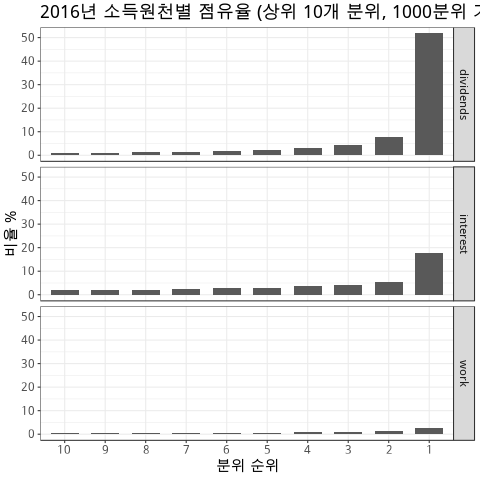

In [46]:
%%R
generate_2016_q(q1000)

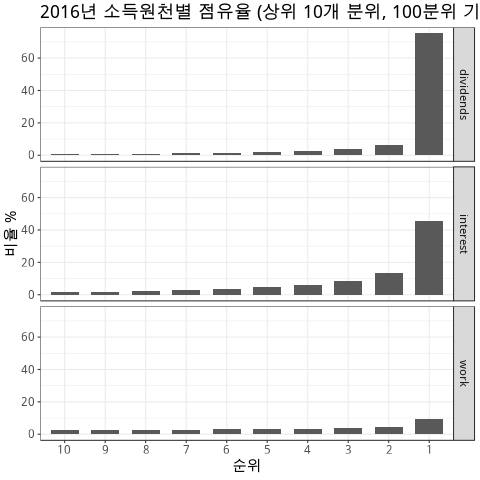

In [48]:
%%R 
generate_2016_q(q100)

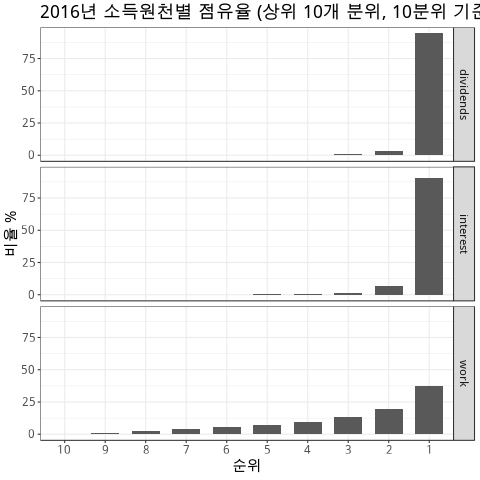

In [49]:
%%R 
generate_2016_q(q10)

### 지니계수 

* 각 소득원천별로 지니계수를 계산해 보자. 
* 근로소득에 비해서 배당소득과 이자소득은 '압도적으로' 불평등하다. 플로우의 누적합인 스톡, 즉 자산 불평등을 계산해 봤으면 싶은 마음이 드는 대목이다. 

In [14]:
%%R 
df_by_q(q1000, F) %>% 
  summarise(
    gini = Gini(value) %>% sprintf("%#.2f", .)
  ) %>% 
  knitr::kable()



| year|cat       |gini |
|----:|:---------|:----|
| 2016|dividends |0.96 |
| 2016|interest  |0.93 |
| 2016|work      |0.55 |


## 근로 소득의 변화 

* 시각화했을 때 100분위, 1000분위는 다소 애로사항이 있다. 솔루션을 찾을 수 있다면 추후에 다시 해보도록 하자. 
* 아래는 근로소득의 10분위 분배의 변화를 시각화한 것이다.
* 일단 2013년에서 2014년 사이에 하위 분위에서 점유율 증가가 눈에 들어온다. 통계작성의 변화 등이 없었다면, 꽤 주목할만한 변화다. 
    * 박근혜 정권이라고 나쁜 일만 했겠는가...
    * 좌간 하위 계층 복지에 있어서 집계든 실질 혜택이든 나름의 변화가 감지되는 시기인 듯. 

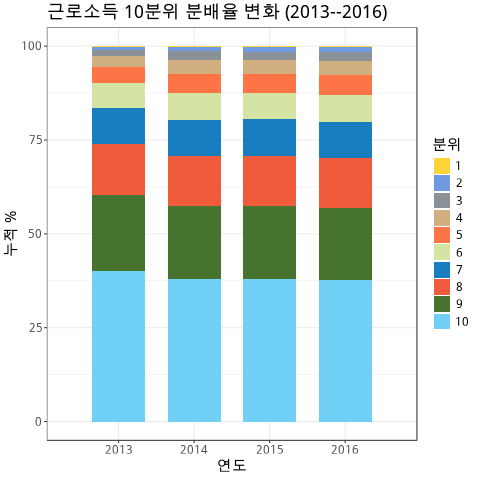

In [50]:
%%R
generate_work_q(q10)

* 하위 5개 분위의 변화를 보다 자세하게 보면 아래와 같다. 1~5 분위 모두 고르게 증가했음을 알 수 있다. 

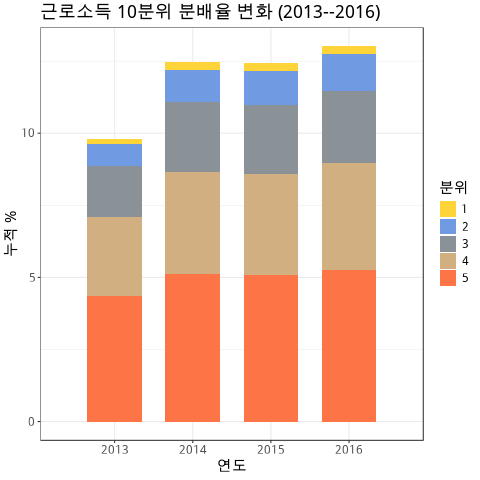

In [51]:
%%R
generate_work_q(q10, seq(1,5,1))

* 노동 소득의 지니계수 변화 역시 같은 방향을 보여준다. 2013년의 0.59에서 0.56으로 크게 낮아졌고, 이후는 추세가 유지되고 있는 형태다.  

In [17]:
%%R
df_by_q(q1000, T) %>% 
  summarise(
    gini = Gini(value) %>% sprintf("%#.2f", .)
  ) %>% 
  knitr::kable()



| year|cat  |gini |
|----:|:----|:----|
| 2013|work |0.59 |
| 2014|work |0.56 |
| 2015|work |0.56 |
| 2016|work |0.55 |


# The end of document 